In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Positive Datasets

In [2]:
outfiles = [f for f in os.listdir() if '_out.csv' in f]
# formatted in data_extraction.ipynb & scraping.ipynb
len(outfiles)

13

In [3]:
positive = pd.concat([pd.read_csv(file) for file in outfiles], ignore_index=True)
positive.drop(['Unnamed: 0'], axis = 1, inplace=True)
positive.head()

,id,name,AB,description,OX,dataset,seq
0,AVP0722,-AVP0722,1,None,alien,InverPep.fasta,NNLETTAFHRDDHET
1,BaAMPS_212,LF11-324,1,None,alien,InverPep.fasta,PFFWRIRIRR
2,DBAASP1220,PYL,1,None,alien,InverPep.fasta,ADADDDDDK
3,PEP12987,Putative,1,None,alien,InverPep.fasta,MRVIAVTLIALLVAGALMTSSAQEEENQVAHVRVRRGFGCPFDQGA...
4,DBAASP359,N-Magainin-C,1,None,alien,InverPep.fasta,APKAMHSAKKFGKAFVGEIMLQKKGI


In [4]:
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54166 entries, 0 to 54165
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54166 non-null  object
 1   name         54162 non-null  object
 2   AB           54166 non-null  int64 
 3   description  36695 non-null  object
 4   OX           53775 non-null  object
 5   dataset      54166 non-null  object
 6   seq          54166 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.9+ MB


In [156]:
positive.describe()

,AB
count,54166.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


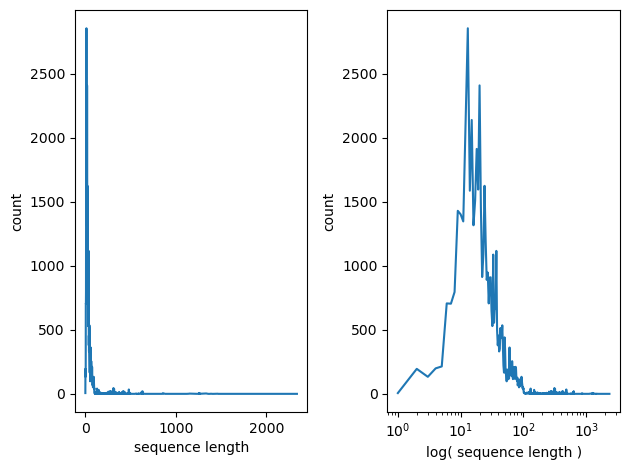

In [157]:
## sequence lengths
ls = positive.seq.map(len).value_counts()
ls = ls.sort_index()
fig, ax = plt.subplots(1, 2)
ax[0].plot(list(ls.index), ls.values)
ax[1].plot(list(ls.index), ls.values)
for a in ax:
    #a.set_xlabel('sequence length')
    a.set_ylabel('count')
ax[0].set_xlabel('sequence length')
ax[1].set_xlabel('log( sequence length )')
ax[1].set_xscale('log')
fig.tight_layout()


# removing non-natural amino acids

In [158]:
###


In [159]:
aadict = []

def aa_in_all_seq(s, aadict = aadict):# might have to add aadict = aadict
    s = s.strip(' ').strip('\n')
    
    aal = re.findall('[A-Z][^A-Z]*', s) # splitting before any capital, checking for aa notation

    aadict += aal
    return s


In [160]:
positive.seq.map(aa_in_all_seq)
aalen1 = [a for a in list(set(aadict)) if len(a) == 1]# seems normal
aalen2 = [a for a in list(set(aadict)) if len(a) == 2]
aalen3 = [a for a in list(set(aadict)) if len(a) > 2]# elements dont seem to be three letter codes

drop_aa = aalen2+aalen3

Asx	B	Aspartic acid or Asparagine  
Glx	Z	Glutamic acid or Glutamine  
Xaa	X	Any amino acid  
Xle	J	Leucine or Isoleucine  

In [161]:
# aalen1 remove X, 
drop_aa += ['X']

In [162]:
# deleting all sequences that contain non-natural aa

pos = positive.copy()

print('df shape before deselecting nn aa: ', pos.shape)

drop_nn = lambda x: any( map(lambda v : v in drop_aa, re.findall('[A-Z][^A-Z]*', x) ) )

pos = pos[ np.invert( pos.seq.map(drop_nn) ) ]

print('df shape after deselecting nn aa: ', pos.shape)

df shape before deselecting nn aa:  (54166, 7)
df shape after deselecting nn aa:  (51123, 7)


In [163]:
pos['seq'] = pos.seq.str.upper()

In [164]:
# adding column seq_len for easier manipulation
pos['seq_len'] = pos.seq.map(len)
pos.head(2)

,id,name,AB,description,OX,dataset,seq,seq_len
0,AVP0722,-AVP0722,1,None,alien,InverPep.fasta,NNLETTAFHRDDHET,15
1,BaAMPS_212,LF11-324,1,None,alien,InverPep.fasta,PFFWRIRIRR,10


# removing seq duplicates

nr samples before:  51123
nr samples after:  24070


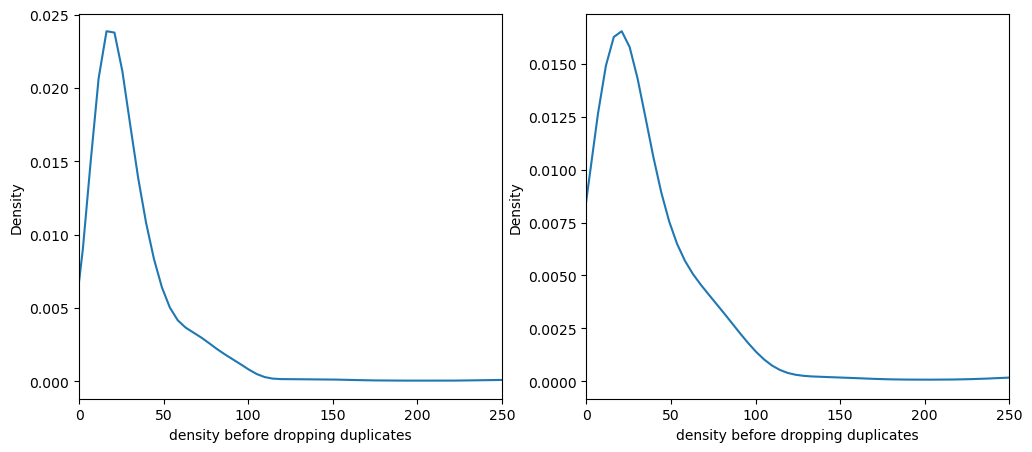

In [165]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

pos.seq_len.plot(kind='kde', ax = ax[0])
ax[0].set_xlabel('density before dropping duplicates')
ax[0].set_xlim(0, 250)
print('nr samples before: ', pos.shape[0])

pos = pos.drop_duplicates(subset=['seq'])

pos.seq_len.plot(kind='kde', ax = ax[1])
ax[1].set_xlabel('density before dropping duplicates')
ax[1].set_xlim(0, 250)
print('nr samples after: ', pos.shape[0])


# deciding on seq_length cut off

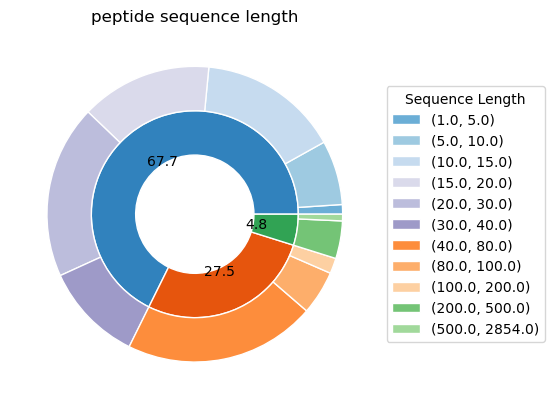

In [166]:
ls = pos.seq.map(len).values#.value_counts()


outer = np.histogram(ls, [1.000e+00, 4e+01, 2e+02, 2.854e+03])

inner = np.histogram(ls, bins = [1e+00, 5e+00, 1e+01, 15, 20, 3e+01, 4e+01, 8e+01, 1e+02, 2e+02, 5e+02, 2.854e+03])

fig, ax = plt.subplots()

size = 0.3

cmap = plt.colormaps['tab20c']#["viridis"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = np.vstack( (cmap([1, 2, 3, 15, 14, 13]) , cmap([5, 6, 7]), cmap([9, 10]))  )


def labeling(x):
    return f'{x:.1f}'#%\n({absolute:d} g)"
# in ax
l_labels = list(zip ( inner[1][:-1], inner[1][1:] ) ) 

# if want labeling add in ,autopct=lambda x: labeling(x), need one more variable unpacked

wedges, text, autotexts = ax.pie(outer[0], radius=1-size, colors=outer_colors, autopct=lambda x: labeling(x),
       wedgeprops=dict(width=size, edgecolor='w'))

wedgesi, autotexts = ax.pie(inner[0], radius=1, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='peptide sequence length')

ax.legend(wedgesi, l_labels,# ingred like text
          title="Sequence Length",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

#plt.setp(autotexts, size=8, weight="bold")

plt.show()

Text(0.5, 0, 'sequence length')

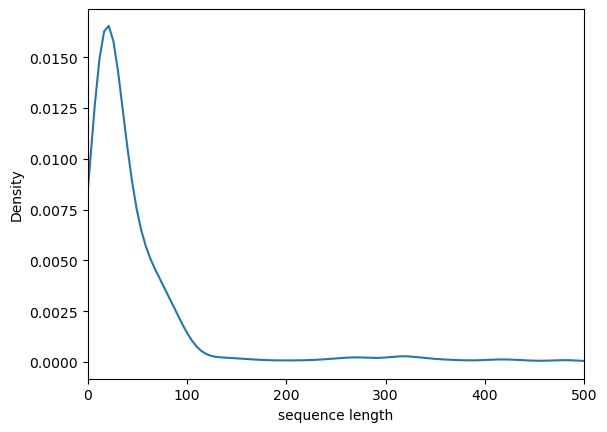

In [167]:
pos['seq'].map(len).plot(kind='kde')
plt.xlim(0, 500)
plt.xlabel('sequence length')

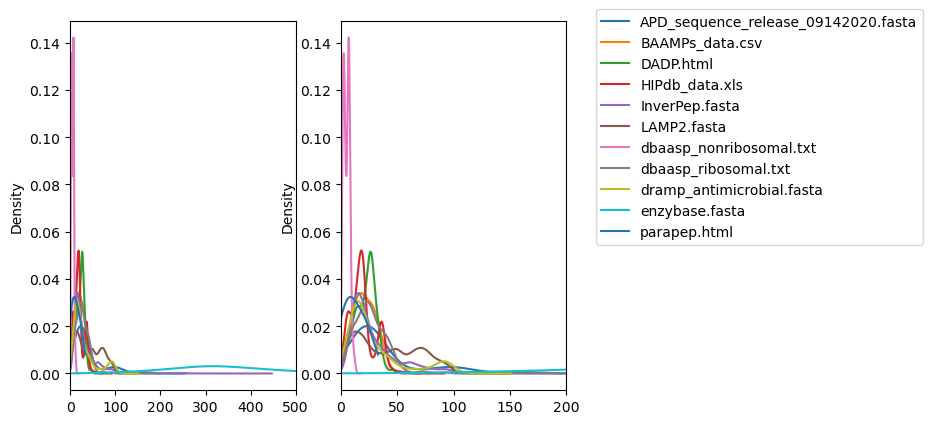

In [169]:
datafig, ax = plt.subplots(1, 2)
pos.groupby('dataset')['seq_len'].plot(kind = 'kde', ax = ax[0])
ax[0].set_xlim(0, 500)
pos.groupby('dataset')['seq_len'].plot(kind = 'kde', ax = ax[1])
ax[1].set_xlim(0, 200)
ax[1].legend(bbox_to_anchor=(1.1, 1.05))

In [170]:
# dropping lengths below 2 and over 70
print('shape before: ', pos.shape)

pos = pos[pos['seq_len'] != 0 ]
print('shape after dropping len== 0: ', pos.shape)

pos = pos[pos['seq_len'] != 1 ]
print('shape after dropping len== 1: ', pos.shape)

pos = pos[pos['seq_len'] != 2 ]
print('shape after dropping len== 2: ', pos.shape)

pos = pos[pos['seq_len'] < 70 ]
print('shape after dropping len > 70: ', pos.shape)

shape before:  (24070, 8)
shape after dropping len== 0:  (24070, 8)
shape after dropping len== 1:  (24068, 8)
shape after dropping len== 2:  (23980, 8)
shape after dropping len > 70:  (20208, 8)


In [171]:
# dropping datasets with unsuitable length distribution
print('shape before: ', pos.shape)
dropdatasets = ['enzybase.fasta', 'parapep.html', 'dbaasp_nonribosomal.txt', 'peptaibol.html' ]
pos = pos[pos['dataset'].map(lambda x: x not in dropdatasets) ]
print('shape after dropping datasets: ', pos.shape)

shape before:  (20208, 8)
shape after dropping datasets:  (20154, 8)


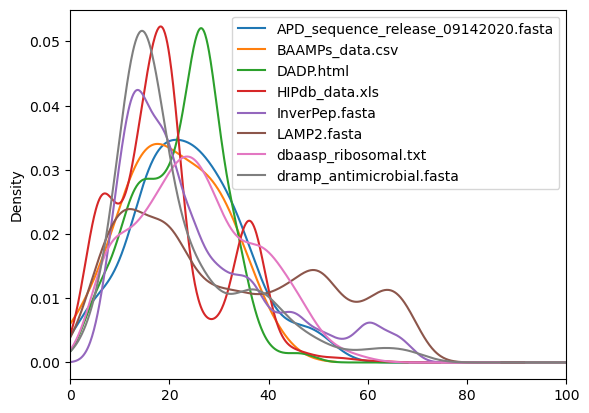

In [172]:
pos.groupby('dataset')['seq_len'].plot(kind = 'kde')

plt.xlim(0, 100)

plt.legend()

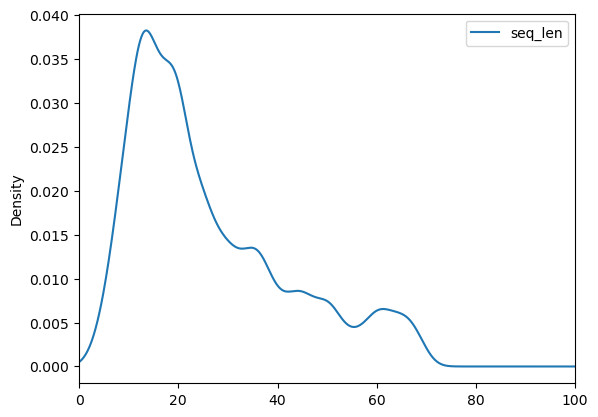

In [173]:
pos['seq_len'].plot(kind = 'kde')

plt.xlim(0, 100)

plt.legend()

# looking at aa dist

In [174]:
def aa_dist(df):
    dist = []
    for s in df.seq:
        split = re.findall('[A-Z][^A-Z]*', s)
        dist += split

    return dist

In [175]:
aadist = aa_dist(pos)
aadist = pd.Series(aadist)
aadist = aadist.value_counts()
aadist

K    57893
L    50516
G    45462
R    38895
A    38306
I    30360
C    30235
V    29667
S    28013
P    23460
F    22554
T    20995
N    19103
E    18754
Q    14610
D    14029
Y    12750
W    12299
H    11169
M     7719
O       59
Z       38
X       26
B       17
U       12
J        3
dtype: int64

In [176]:
#!! why is there still X
# also drop O, Z, X, B U , J as there are very few instances

print('df shape before deselecting nn aa: ', pos.shape)

drop_aa = ['O', 'Z', 'X', 'B', 'U', 'J']

drop_nn = lambda x: any( map(lambda v : v in drop_aa, re.findall('[A-Z][^A-Z]*', x) ) )

pos = pos[ np.invert( pos.seq.map(drop_nn) ) ]

print('df shape after deselecting nn aa: ', pos.shape)

df shape before deselecting nn aa:  (20154, 8)
df shape after deselecting nn aa:  (20114, 8)


In [177]:
aadist = aa_dist(pos)
aadist = pd.Series(aadist)
aadist = aadist.value_counts()
aadist

K    57825
L    50429
G    45387
R    38804
A    38255
I    30321
C    30200
V    29636
S    27973
P    23398
F    22541
T    20965
N    19085
E    18737
Q    14593
D    14022
Y    12719
W    12284
H    11145
M     7713
dtype: int64

In [178]:
summeddists = aadist.values #np.append(aadist.values[:-6], sum(aadist.values[-6:]) )
summeddistslabels = aadist.index #list( aadist.index[:-6] )+['X, O, Z, B, U, J' ]

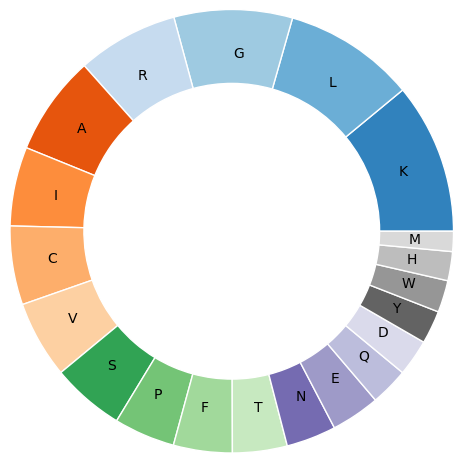

In [179]:
cmap = plt.colormaps['tab20c']
outer_colors = cmap(np.arange(len(summeddists)))

fig, ax = plt.subplots()
size = 0.5
wedges, text = ax.pie(summeddists, radius=1.5, colors=outer_colors, 
                      labels=summeddistslabels, labeldistance=0.8,
       wedgeprops=dict(width=size, edgecolor='w'))

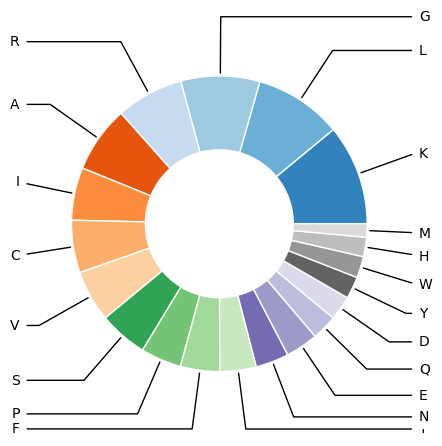

In [180]:
fig, ax = plt.subplots()
size = 0.5
wedges, text = ax.pie(aadist.values, radius=1, colors=outer_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(aadist.index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

# Negative Samples

from uniprot -> swissprot https://www.uniprot.org/uniprotkb?query=reviewed:true  
set length: -200, protein experimental ('The value 'Experimental evidence at protein level' indicates that there is clear experimental evidence for the existence of the protein. The criteria include partial or complete Edman sequencing, clear identification by mass spectrometry, X-ray or NMR structure, good quality protein-protein interaction or detection of the protein by antibodies.')



In [181]:
#for fasta swissprot
"""
sp|UniqueIdentifier|EntryName 
OX = organism identifier
GN = gene name
PE = protein existence
SV = version number of sequence
"""
def swissprottopd(infile, ofile):
  with open(infile, 'r') as inf:
    flines = inf.readlines()

    print('input file', infile)

    seqs = {}
    lastname = 'None'

    for l in flines:
      if l[0]=='>':# sequence identifier
        id, rest = l.strip('>sp|') .split('|', 1)
        name, rest = rest.split(' ', 1)
        desc, org = rest.split('OS=', 1)

        # need initialisation as have multiline sequences that require +=
        org = org.split(' PE')[0]
        seq = {'id':id, 'name':name, 'AB':0, 'description':desc, 'OX': org, 'dataset':infile, 'seq':''}
        seqs[name] = seq
        lastname = name

      else:
        seq = seqs[lastname]
        seq['seq'] += l.strip('>').strip('\n').strip(' ')
        #print(seq['seq'], len( seq['seq']) )

  inf.close()

  df = pd.DataFrame.from_dict(seqs, orient='index')#.transpose()
  return df

In [182]:
negative = swissprottopd('uniprot_swissprot.fasta', 'uniprot_swissprot')
print(negative.shape)
negative.head(3)


input file uniprot_swissprot.fasta
(31975, 7)


,id,name,AB,description,OX,dataset,seq
CA18_CONBE,A0A068B6Q6,CA18_CONBE,0,Conotoxin Bt1.8 (Fragment),Conus betulinus OX=89764,uniprot_swissprot.fasta,PDGRNAAAKAFDLITPTVRKGCCSNPACILNNPNQCG
BRKP2_PHYNA,A0A088MIT0,BRKP2_PHYNA,0,Bradykinin-related peptides,Physalaemus nattereri OX=248869 GN=BBN,uniprot_swissprot.fasta,MAFLKKSLFLVLFLGVVSLSFCEEEKREEHEEEKRDEEDAESLGKR...
DEFCO_COPCI,A0A097PTA8,DEFCO_COPCI,0,Fungal defensin copsin,Coprinopsis cinerea OX=5346,uniprot_swissprot.fasta,MKLSTSLLAIVAVASTFIGNALSATTVPGCFAECIDKAAVAVNCAA...


In [183]:
negative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31975 entries, CA18_CONBE to AP_FRAAN
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           31975 non-null  object
 1   name         31975 non-null  object
 2   AB           31975 non-null  int64 
 3   description  31975 non-null  object
 4   OX           31975 non-null  object
 5   dataset      31975 non-null  object
 6   seq          31975 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.0+ MB


In [184]:
negative.describe()

,AB
count,31975.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [185]:

negative.seq.map(len).value_counts()

11     460
146    409
10     378
15     328
141    323
      ... 
5       36
6       33
4       23
3        5
2        2
Name: seq, Length: 199, dtype: int64

In [186]:
negative.seq.map(len).values.max()#.value_counts().index

200

## removing nn amino acis

In [192]:
drop_aa = aalen2 + aalen3 + ['O', 'Z', 'X', 'B', 'U', 'J']

In [193]:
print('df shape before deselecting nn aa: ', negative.shape)

drop_nn = lambda x: any( map(lambda v : v in drop_aa, re.findall('[A-Z][^A-Z]*', x) ) )

negative = negative[ np.invert( negative.seq.map(drop_nn) ) ]

print('df shape after deselecting nn aa: ', negative.shape)

df shape before deselecting nn aa:  (31975, 7)
df shape after deselecting nn aa:  (31096, 7)


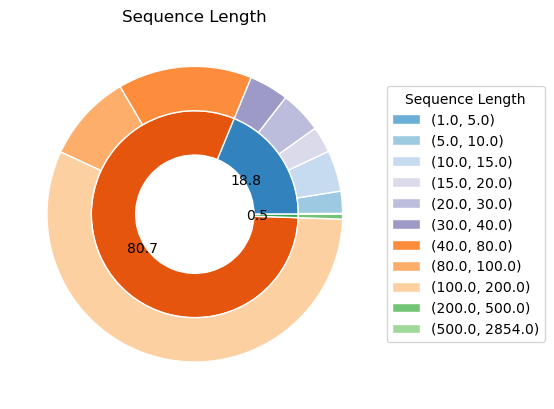

In [194]:
# ame bins as for positives. ? get non zero in bins > len 200?

ls = negative.seq.map(len).values#.value_counts()

outer = np.histogram(ls, [1.000e+00, 4e+01, 2e+02, 2.854e+03])
inner = np.histogram(ls, bins = [1e+00, 5e+00, 1e+01, 15, 20, 3e+01, 4e+01, 8e+01, 1e+02, 2e+02, 5e+02, 2.854e+03])

fig, ax = plt.subplots()

size = 0.3

cmap = plt.colormaps['tab20c']#["viridis"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = np.vstack( (cmap([1, 2, 3, 15, 14, 13]) , cmap([5, 6, 7]), cmap([9, 10]))  )


def labeling(x):
    return f'{x:.1f}'#%\n({absolute:d} g)"
# in ax
l_labels = list(zip ( inner[1][:-1], inner[1][1:] ) ) 

# if want labeling add in ,autopct=lambda x: labeling(x), need one more variable unpacked

wedges, text, autotexts = ax.pie(outer[0], radius=1-size, colors=outer_colors, autopct=lambda x: labeling(x),
       wedgeprops=dict(width=size, edgecolor='w'))

wedgesi, autotexts = ax.pie(inner[0], radius=1, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Sequence Length')

ax.legend(wedgesi, l_labels,# ingred like text
          title="Sequence Length",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

#plt.setp(autotexts, size=8, weight="bold")

plt.show()

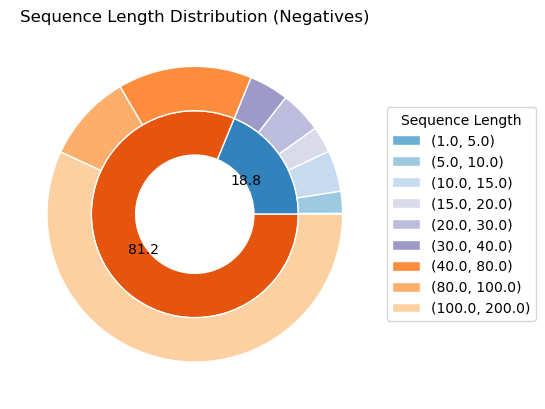

In [195]:
ls = negative.seq.map(len).values#.value_counts()
# removed slice of largest values (>200)

outer = np.histogram(ls, [1.000e+00, 4e+01, 2e+02])
inner = np.histogram(ls, bins = [1e+00, 5e+00, 1e+01, 15, 20, 3e+01, 4e+01, 8e+01, 1e+02, 2e+02])

fig, ax = plt.subplots()

size = 0.3

cmap = plt.colormaps['tab20c']#["viridis"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = np.vstack( (cmap([1, 2, 3, 15, 14, 13]) , cmap([5, 6, 7]) )  )



def labeling(x):
    return f'{x:.1f}'#%\n({absolute:d} g)"
# in ax
l_labels = list(zip ( inner[1][:-1], inner[1][1:] ) ) 

# if want labeling add in ,autopct=lambda x: labeling(x), need one more variable unpacked

wedges, text, autotexts = ax.pie(outer[0], radius=1-size, colors=outer_colors, autopct=lambda x: labeling(x),
       wedgeprops=dict(width=size, edgecolor='w'))

wedgesi, autotexts = ax.pie(inner[0], radius=1, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Sequence Length Distribution (Negatives)')

ax.legend(wedgesi, l_labels,# ingred like text
          title="Sequence Length",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

#plt.setp(autotexts, size=8, weight="bold")

plt.show()

## dropping len()>70 & len()<2

In [196]:
print(negative.shape)
negative = negative[ negative.seq.map(len) < 70 ]
negative = negative[ negative.seq.map(len) > 2 ]
print(negative.shape)

(31096, 7)
(9086, 7)


In [197]:
negative['seq_len'] = negative.seq.map(len)
negative.head(2)

,id,name,AB,description,OX,dataset,seq,seq_len
CA18_CONBE,A0A068B6Q6,CA18_CONBE,0,Conotoxin Bt1.8 (Fragment),Conus betulinus OX=89764,uniprot_swissprot.fasta,PDGRNAAAKAFDLITPTVRKGCCSNPACILNNPNQCG,37
PIOS1_HUMAN,A0A0B4J2F0,PIOS1_HUMAN,0,Protein PIGBOS1,Homo sapiens OX=9606 GN=PIGBOS1,uniprot_swissprot.fasta,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54


In [198]:
print(negative.shape)
negative_n = negative.drop_duplicates(subset=['seq'])
print(negative.shape)

(9086, 8)
(9086, 8)


In [202]:
negseq_todrop = negative.seq.map(lambda x: x in positive.seq.values)
negseq_todrop = np.invert(negseq_todrop)

print(negative.shape)
neg = negative[negseq_todrop]
print(neg.shape)

(9086, 8)
(7417, 8)


# resampling Datasets to match in length distribution

initial idea: fit distribution to best match positive dataset, sample accordingly from negatve

In [203]:
import scipy.stats as stats

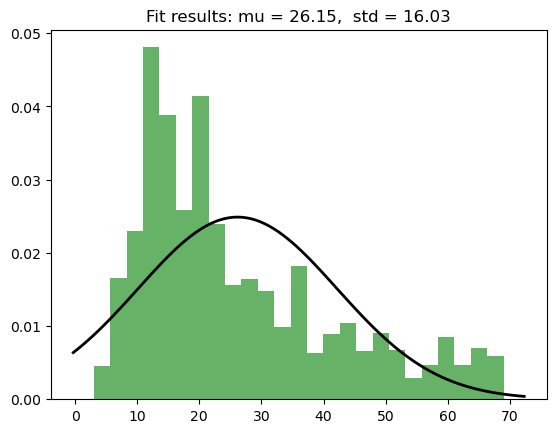

In [204]:
# Fit a normal distribution to the data:
p_seq_len = pos.seq_len
mu, std = stats.norm.fit(p_seq_len)

# Plot the histogram.
plt.hist(p_seq_len, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

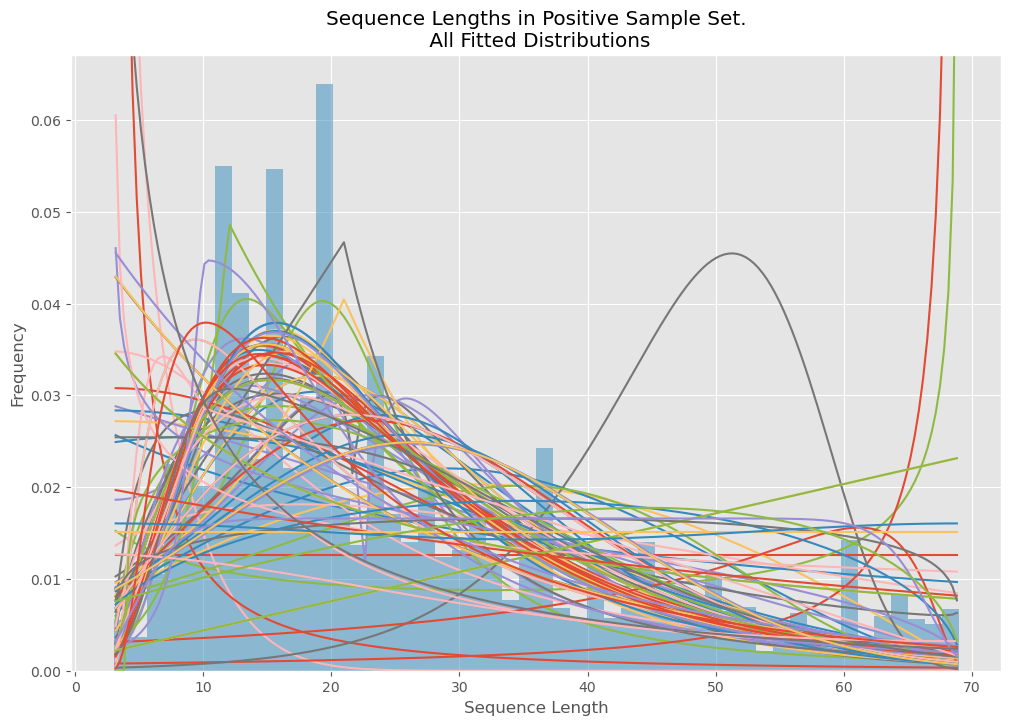

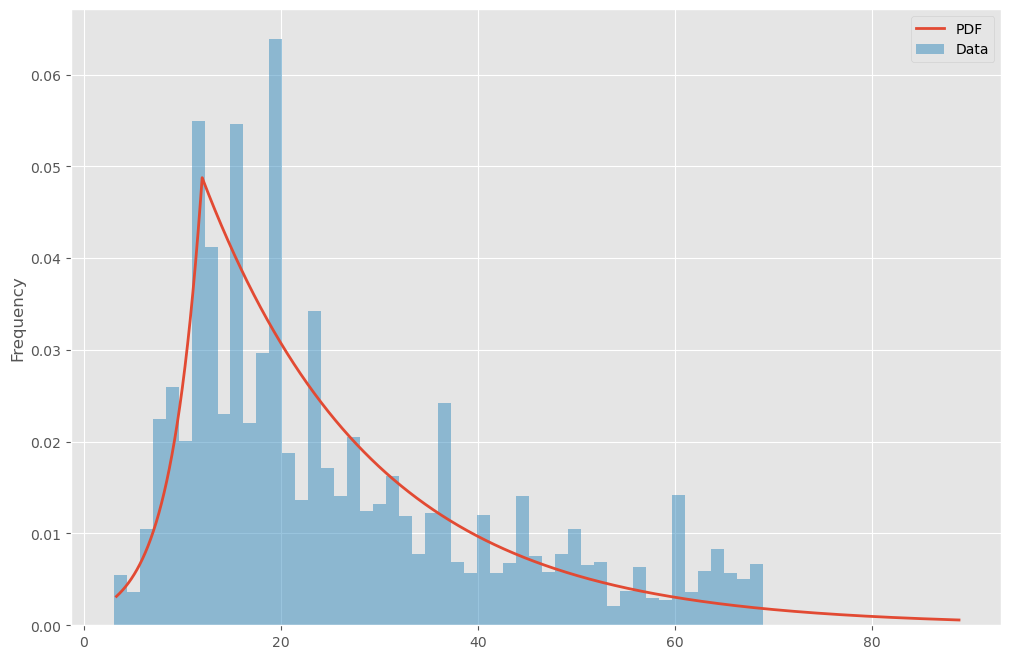

In [205]:
# trying to fit a distribution to length distribution of our positive samples
# code taken from: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
#import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pos.seq_len

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Sequence Lengths in Positive Sample Set.\n All Fitted Distributions')
ax.set_xlabel(u'Sequence Length')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)
print(param_names, param_str, dist_str)

['kappa', 'loc', 'scale'] kappa=0.43, loc=12.00, scale=7.42 laplace_asymmetric(kappa=0.43, loc=12.00, scale=7.42)


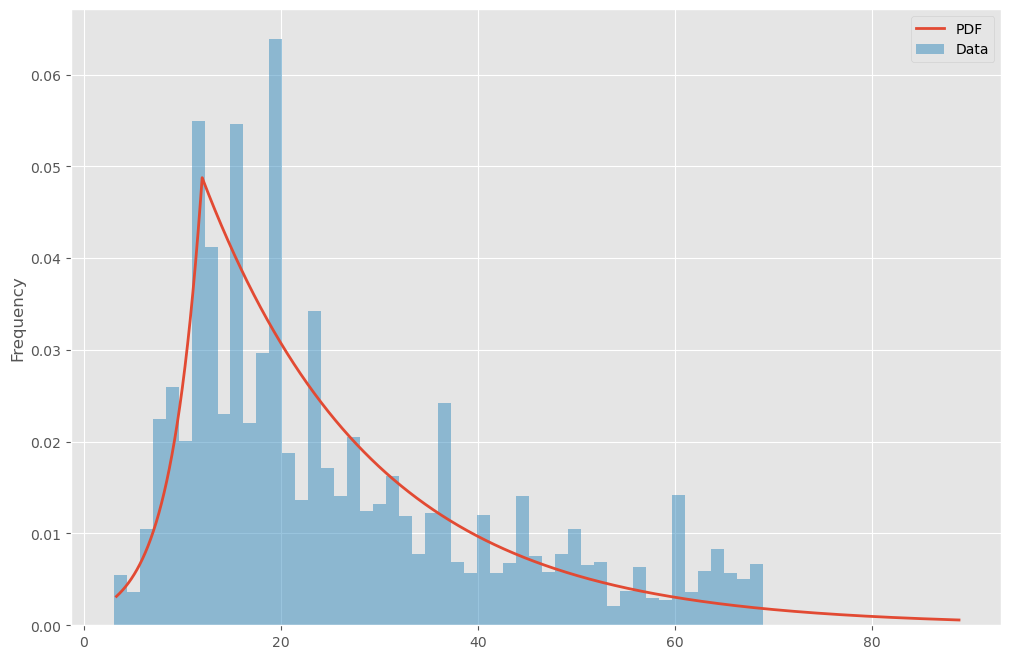

In [206]:
# Make PDF with best params 
data = pos.seq_len
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)
print(param_names, param_str, dist_str)

In [207]:
dist, params = best_dist[0], best_dist[1]
print('sse:', best_dist[2])

arg = params[:-2]
loc = params[-2]
scale = params[-1]

size = 1000

x = np.linspace(0, 100, size)
y = dist.pdf(x, loc=loc, scale=scale, *arg)
pdf = pd.Series(y, x)


sse: 0.16034936717799153


In [209]:
# for negative
data = neg.seq_len

distribution = getattr(st, 'laplace_asymmetric')

# Ignore warnings from data that can't be fit
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    # fit dist to data
    params = distribution.fit(data)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Calculate fitted PDF and error with fit in distribution
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(y - pdf, 2.0))

negative_best_dist = (distribution, params, sse)
        

['kappa', 'loc', 'scale'] kappa=0.20, loc=8.00, scale=5.51 laplace_asymmetric(kappa=0.20, loc=8.00, scale=5.51)


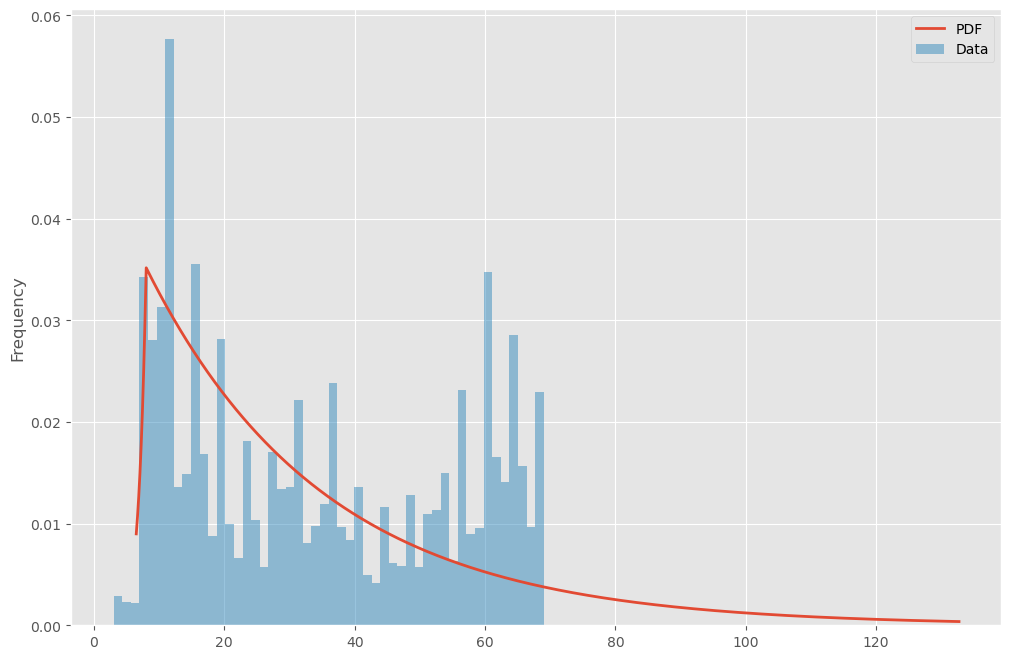

In [210]:
pdf = make_pdf(negative_best_dist[0], negative_best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (negative_best_dist[0].shapes + ', loc, scale').split(', ') if negative_best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, negative_best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)
print(param_names, param_str, dist_str)

## fitted distributions

In [215]:
# https://stats.stackexchange.com/questions/634940/resample-from-a-sample-to-match-a-desired-distribution

# gerenate pdf from fitted distribtuion
#pos exponnorm(K=5.50, loc=8.58, scale=3.12)
x = np.arange(3, 80)
pdist = dist.pdf(x, kappa=0.43, loc=12.00, scale=7.42)
# neg K=0.31, loc=28.46, scale=18.53)
ndist = dist.pdf(x, kappa=0.20, loc=8.00, scale=5.51)

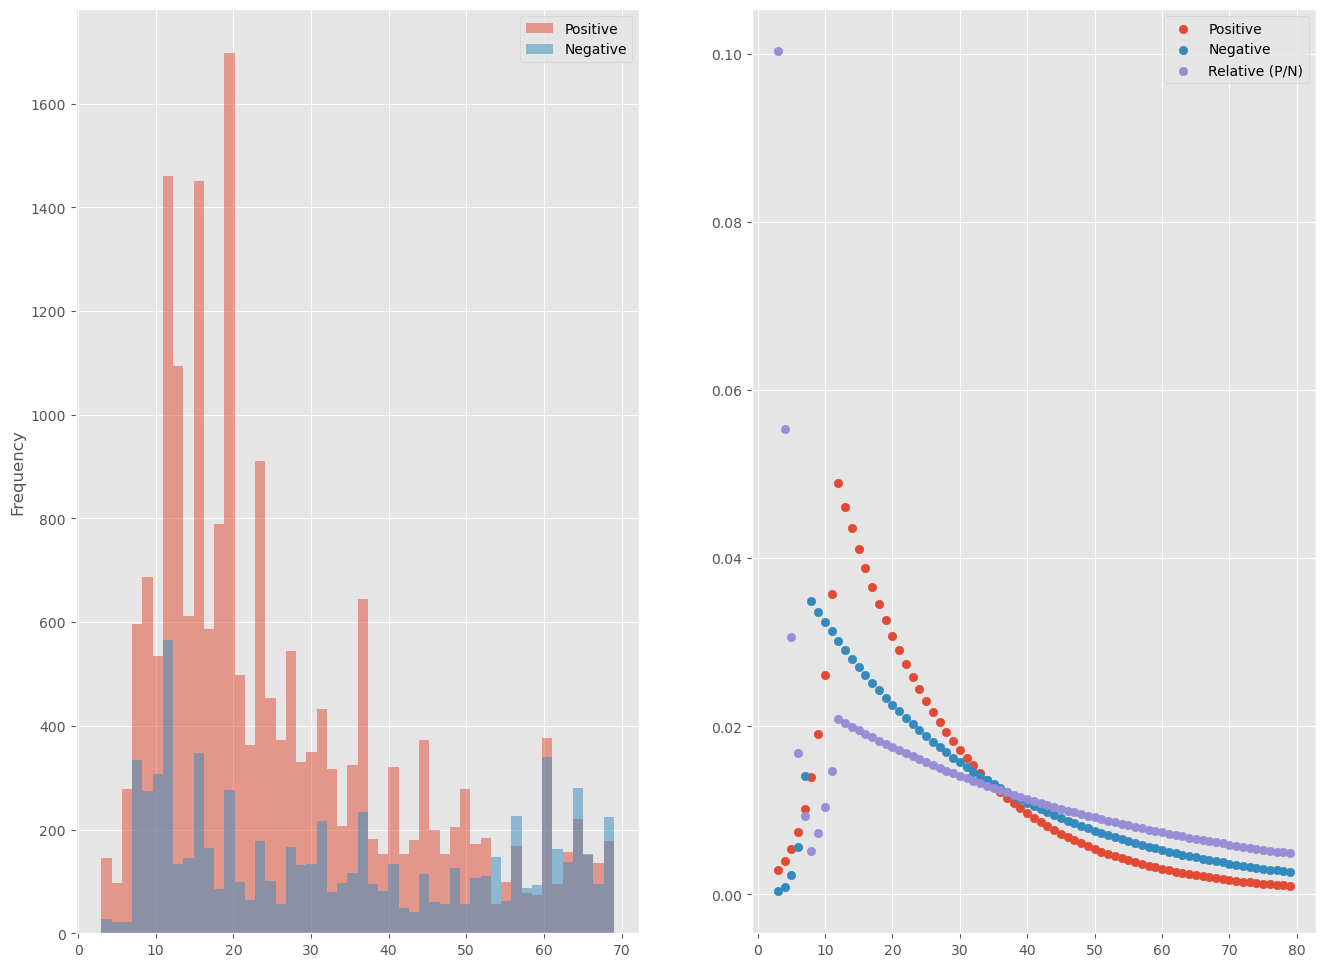

In [218]:
fig, ax = plt.subplots(1, 2)
pos.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Positive', legend=True, ax=ax[0])
neg.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Negative', legend=True, ax=ax[0])


ax[1].scatter(x,  pdist, label='Positive')
ax[1].scatter(x, ndist, label='Negative')
ax[1].scatter(x, pdist/ndist/sum(pdist/ndist), label='Relative (P/N)')
ax[1].legend()

### resampling positive to match negative distribution

In [ ]:
# did not work nicely

### resampling negative to match positive distribution

In [221]:
reldist = pdist/sum(pdist)
n_psamples = (np.round ( reldist*neg.shape[0]) )

In [222]:
groups = neg.groupby(['seq_len'])['name'].agg(list)
groups

seq_len
3     [TRH_PIG, TRH_SHEEP, TRH_NOTVI, TRH_BOMOR, ACI...
4     [OCP1_CALMC, OCP3_CALMC, FMRF_MACNI, TSCO1_AND...
5     [PAP2_PARMA, EUDIS_EUDSF, NDBP8_TITSE, FARP_AR...
6     [COW_CONCS, SAPP_SEPOF, PYF1_PENMO, CUTI2_COLK...
7     [CUTI1_COLKA, FAR1_DELRA, FAR2_DELRA, FAR3_DEL...
                            ...                        
65    [HIRV1_HIRME, SCX4_LEIQU, SCX4_LEIHE, SCX1_ODO...
66    [SCX1_CENBA, SAMP2_HALVD, THIS_ECOLI, SCX2_CEN...
67    [RPAB5_HUMAN, CT5AS_CONTE, RS28A_YEAST, SIM20_...
68    [TX41A_SCOMU, NBDY_HUMAN, FIG01_BOARA, SCXD_CE...
69    [RPOY_BACSU, CSPE_ECOLI, CSPC_ECOLI, CA4A_CONS...
Name: name, Length: 67, dtype: object

In [224]:
nsample_names = []

updated_n_psamples = np.array(n_psamples)#.copy()
used_n_psamples = np.array(n_psamples)# by group set by default + neighbourign group
# not needed if only update first lower

##!!
n_psamples = n_psamples[:len(groups)]
 
def putinothers(j, left, updated_n_psamples, nsample_names):
    data = groups.values[j-1][int(updated_n_psamples[j-1]):]# would change to used_n_p if putinto more than one
    used = 0
    while updated_n_psamples[j-1] > 1 and left>0:
        nsample_names += data[used]
        used += 1
        updated_n_psamples[j-1] -= 1
    return left

    #updated_n_psamples[i+1] += v-len(data)

for i, v in enumerate(n_psamples):# values for len 3..80
    l = i+3
    v = int(v)
    data = groups.values[i]
    if len(data) < v and i>0:
        print(' length, want, have:', l, v, len(data))
        nsample_names += data
        updated_n_psamples[i] = 0 
        lo = putinothers(i, v-len(data), updated_n_psamples, nsample_names)


    else:
        nsample_names += data[:v]#np.random.choice(groups.values[0], v)
        updated_n_psamples[i] -= v 

 length, want, have: 4 30 23
 length, want, have: 5 41 22
 length, want, have: 6 57 21
 length, want, have: 12 371 163
 length, want, have: 13 350 133
 length, want, have: 14 331 146
 length, want, have: 15 312 238
 length, want, have: 16 295 110
 length, want, have: 17 278 165
 length, want, have: 18 262 86
 length, want, have: 19 248 93
 length, want, have: 20 234 183
 length, want, have: 21 220 98
 length, want, have: 22 208 65
 length, want, have: 23 196 96
 length, want, have: 24 185 81
 length, want, have: 25 175 101
 length, want, have: 26 165 56
 length, want, have: 27 156 82
 length, want, have: 28 147 85
 length, want, have: 29 139 131
 length, want, have: 31 123 115
 length, want, have: 32 117 102
 length, want, have: 33 110 79
 length, want, have: 34 104 96
 length, want, have: 41 69 52
 length, want, have: 42 65 48
 length, want, have: 43 62 41
 length, want, have: 45 55 45


In [225]:
len(nsample_names)#!

4948

<AxesSubplot:ylabel='Density'>

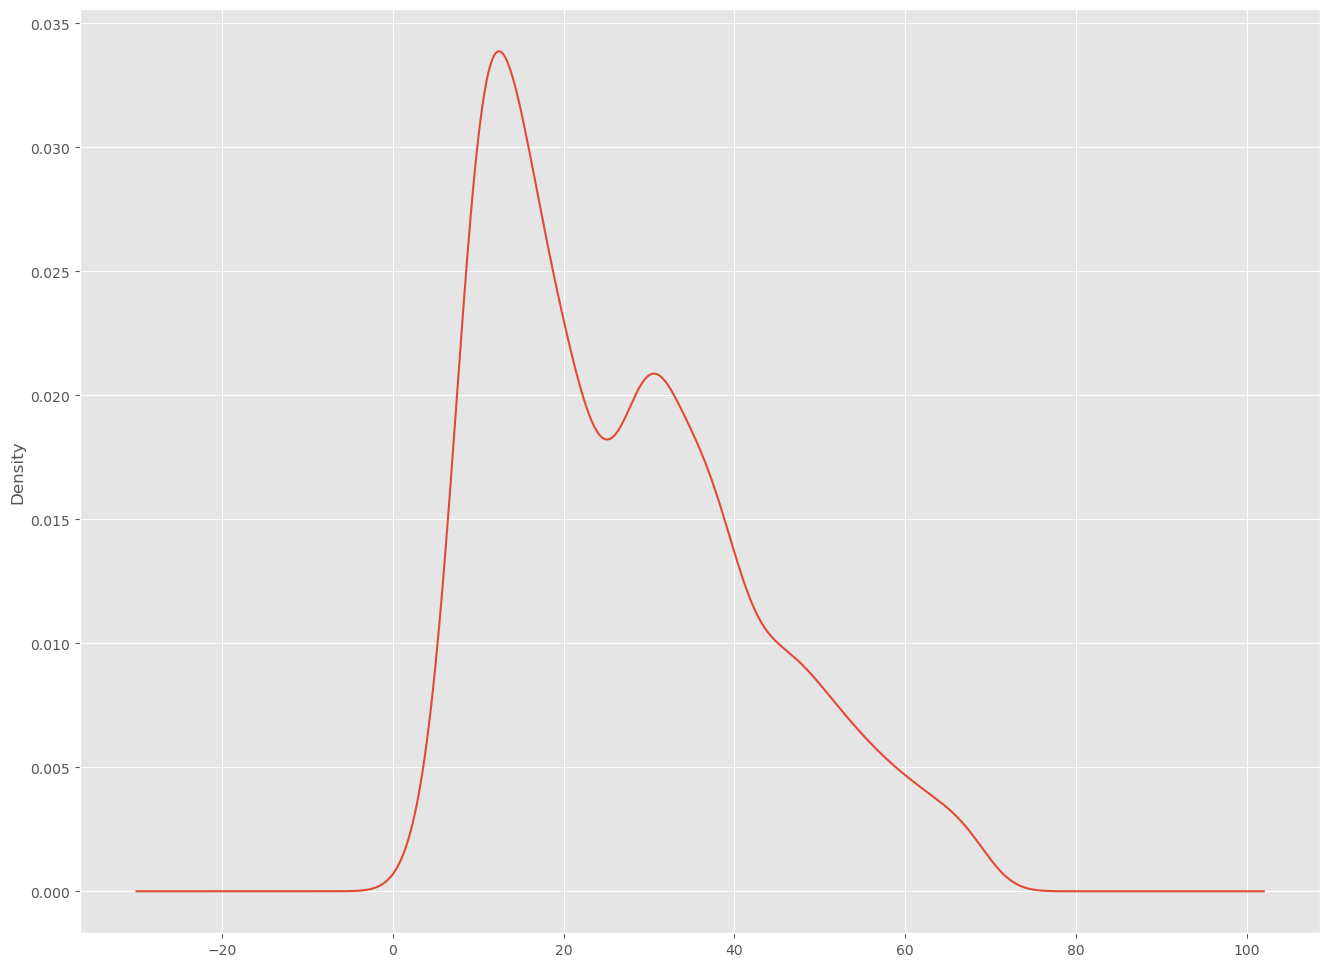

In [227]:
df_n = neg[neg['name'].map(lambda x: x in nsample_names) ]
df_n.head(2)
df_n.seq_len.plot(kind='kde')

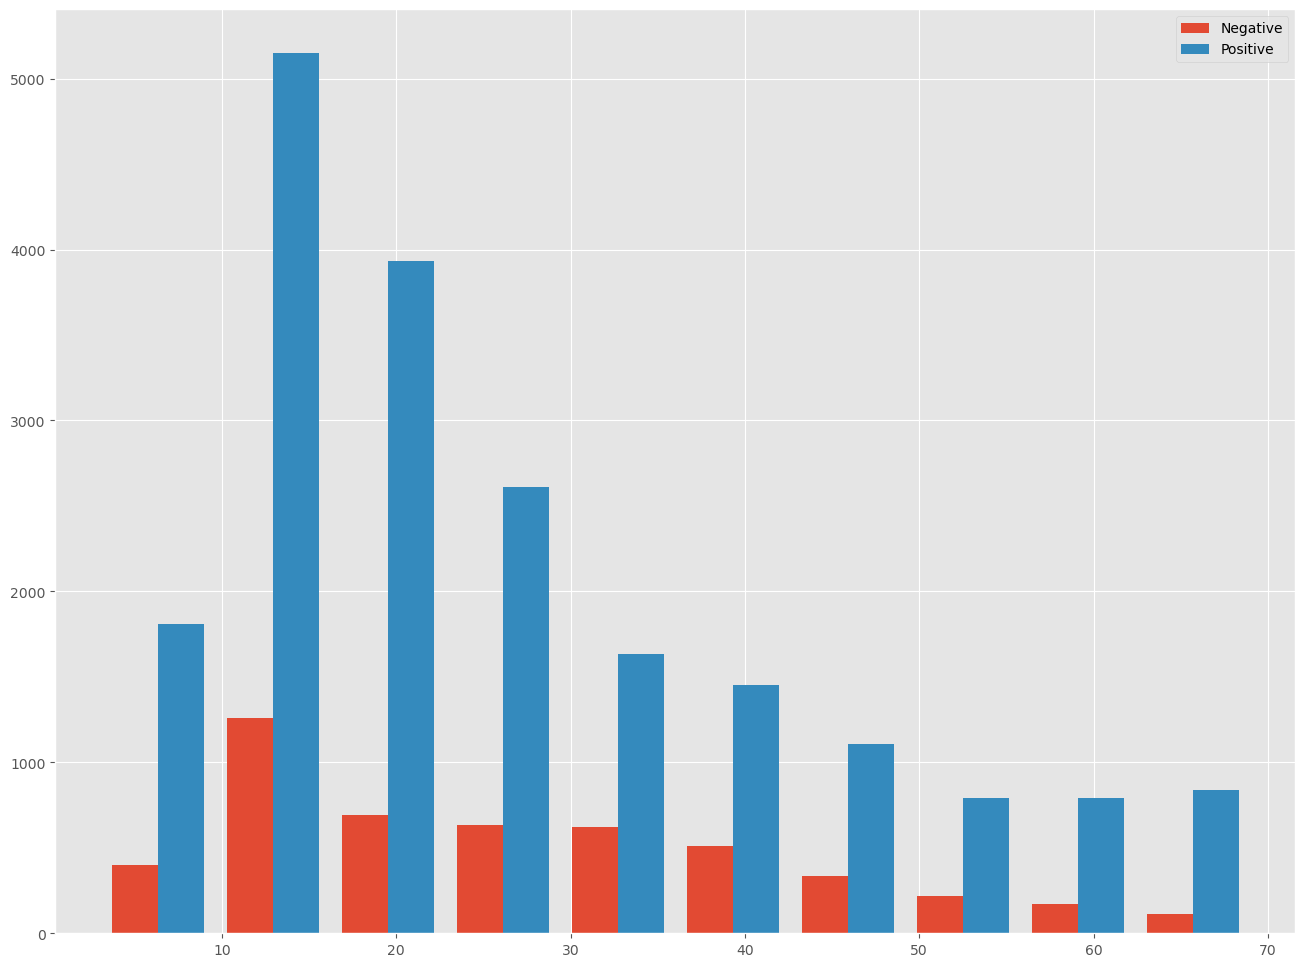

In [232]:
fig, ax = plt.subplots()
ax.hist([df_n.seq_len, pos.seq_len], label = ['Negative', 'Positive'])
ax.legend()

In [229]:
print(df_n.shape[0]/pos.shape[0])

0.2459978124689271


In [230]:
df_p = pos.sample(n=df_n.shape[0], random_state=1)
df_p.shape

(4948, 8)

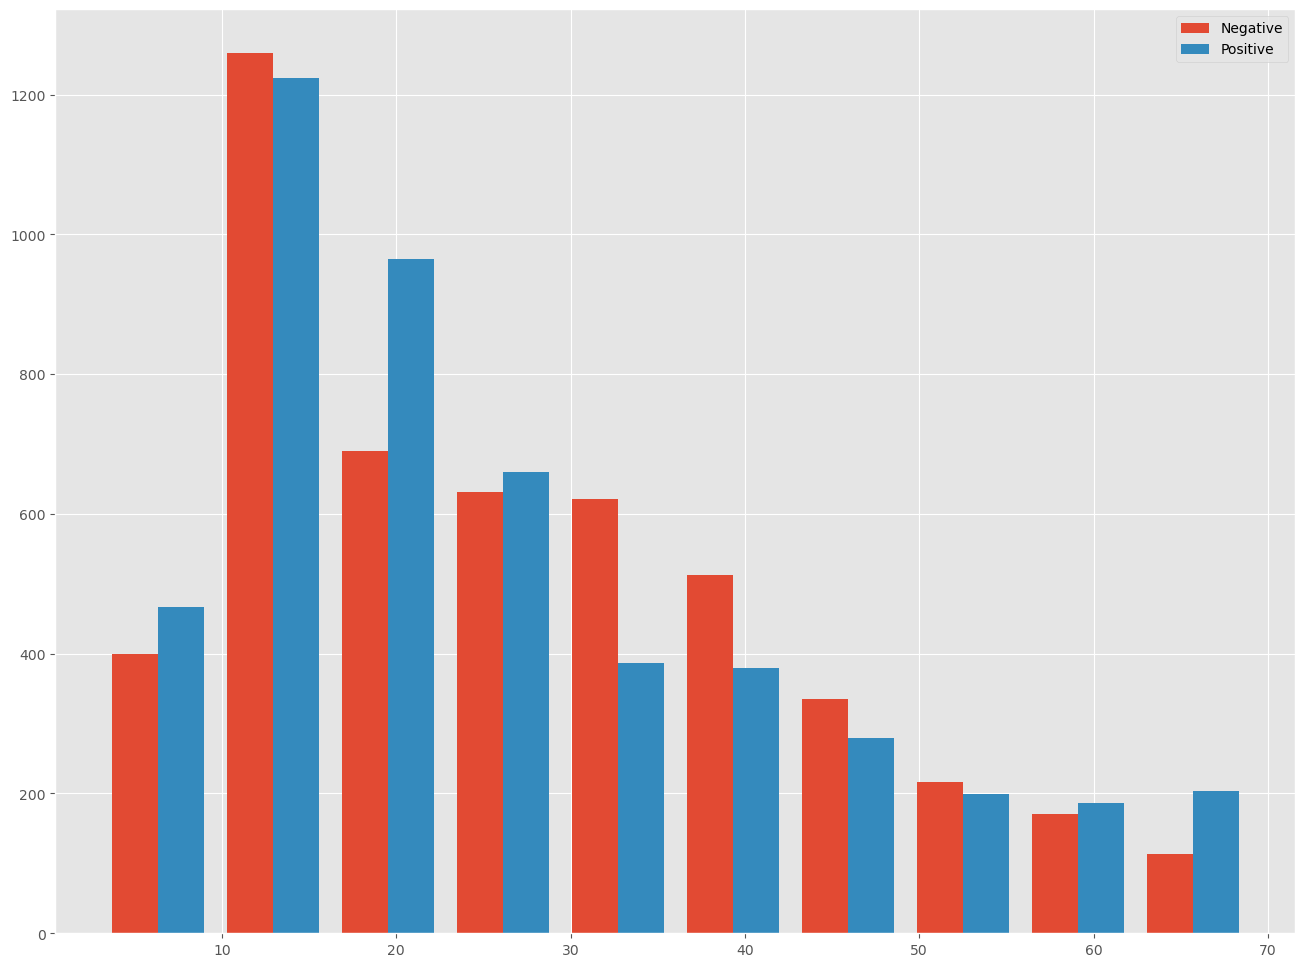

In [233]:
fig, ax = plt.subplots()
ax.hist([df_n.seq_len, df_p.seq_len], label = ['Negative', 'Positive'])
ax.legend()

## drop similar distribution requirement

In [238]:
neg_hist = np.histogram(neg.seq_len)
pos_hist = np.histogram(pos.seq_len, bins = neg_hist[1])

In [248]:
neg_groups = neg.groupby(['seq_len'])['name'].agg(list)
neg_groupl = neg_groups.apply(lambda x : len(x))
pos_groups = pos.groupby(['seq_len'])['name'].agg(list)

pos_groupl = pos_groups.apply(lambda x : len(x))

In [274]:
pos_names = []
neg_names = []

# del len

for i, l in enumerate( pos_groups.index) :# loop over all sequence lengths
    lp = pos_groupl[l]
    ln = neg_groupl[l]

    lmax = max(ln, lp)

    if np.abs(lp-ln) < 0.1 * lmax:
        pos_names += pos_groups[l]
        neg_names += neg_groups[l]
    else:
        lmin = min(ln, lp)
        pos_names += pos_groups[l][:lmin]
        neg_names += neg_groups[l][:lmin]

In [288]:
# choose number pos = neg, but distribution does not need to be exact same
df_n = neg[neg['name'].map(lambda x: x in neg_names) ]
df_p = pos[pos['name'].map(lambda x: x in pos_names) ]
df_p = df_p.sample(n=df_n.shape[0], random_state=1)

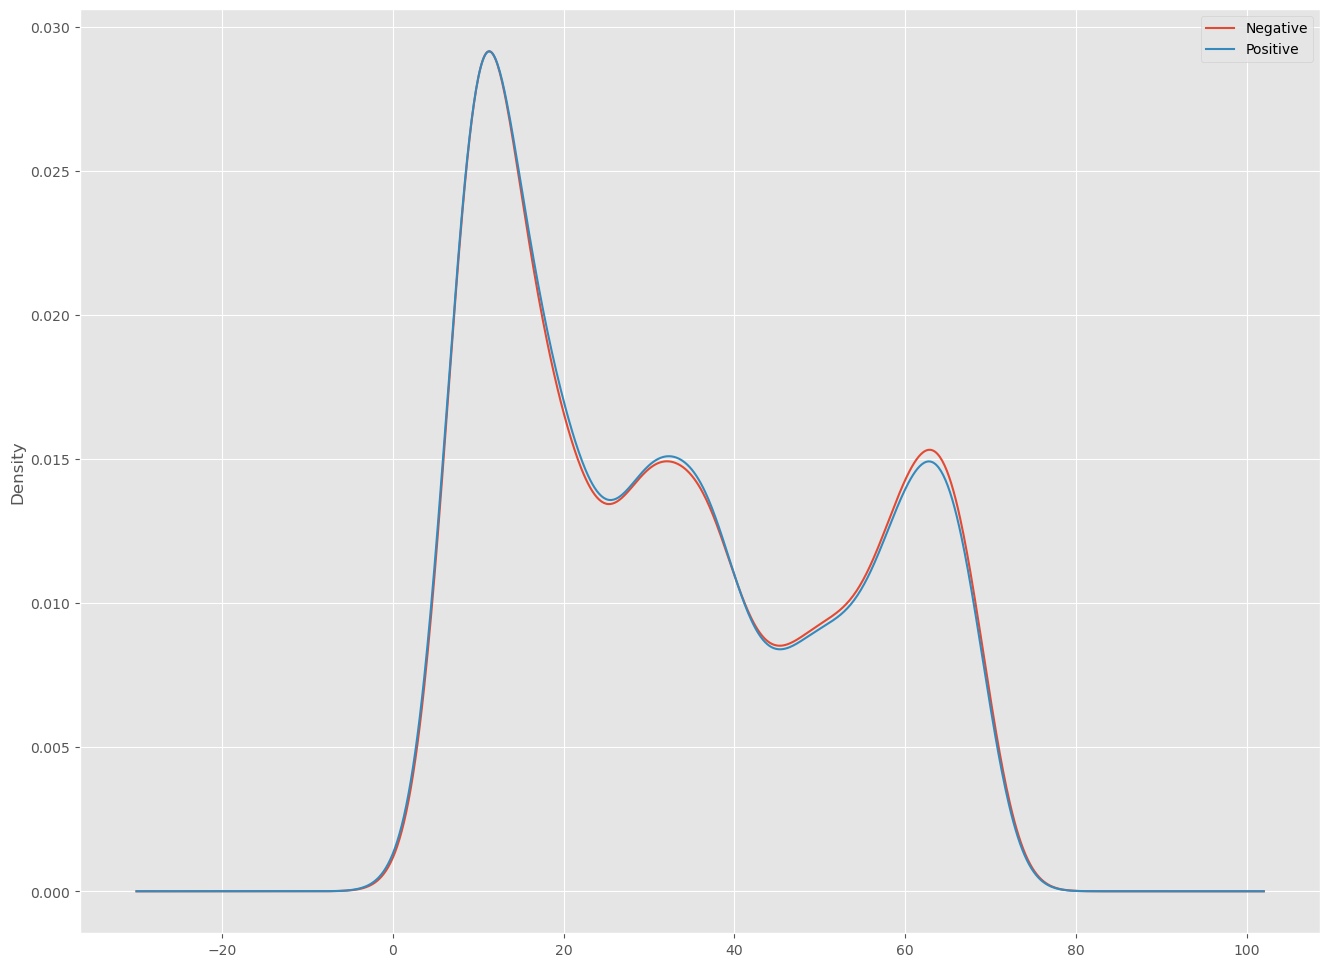

In [290]:
df_n.seq_len.plot(kind='kde', label='Negative')
df_p.seq_len.plot(kind='kde', label = 'Positive')
plt.legend()

Text(0.5, 1.0, 'Length Distribution after resampling')

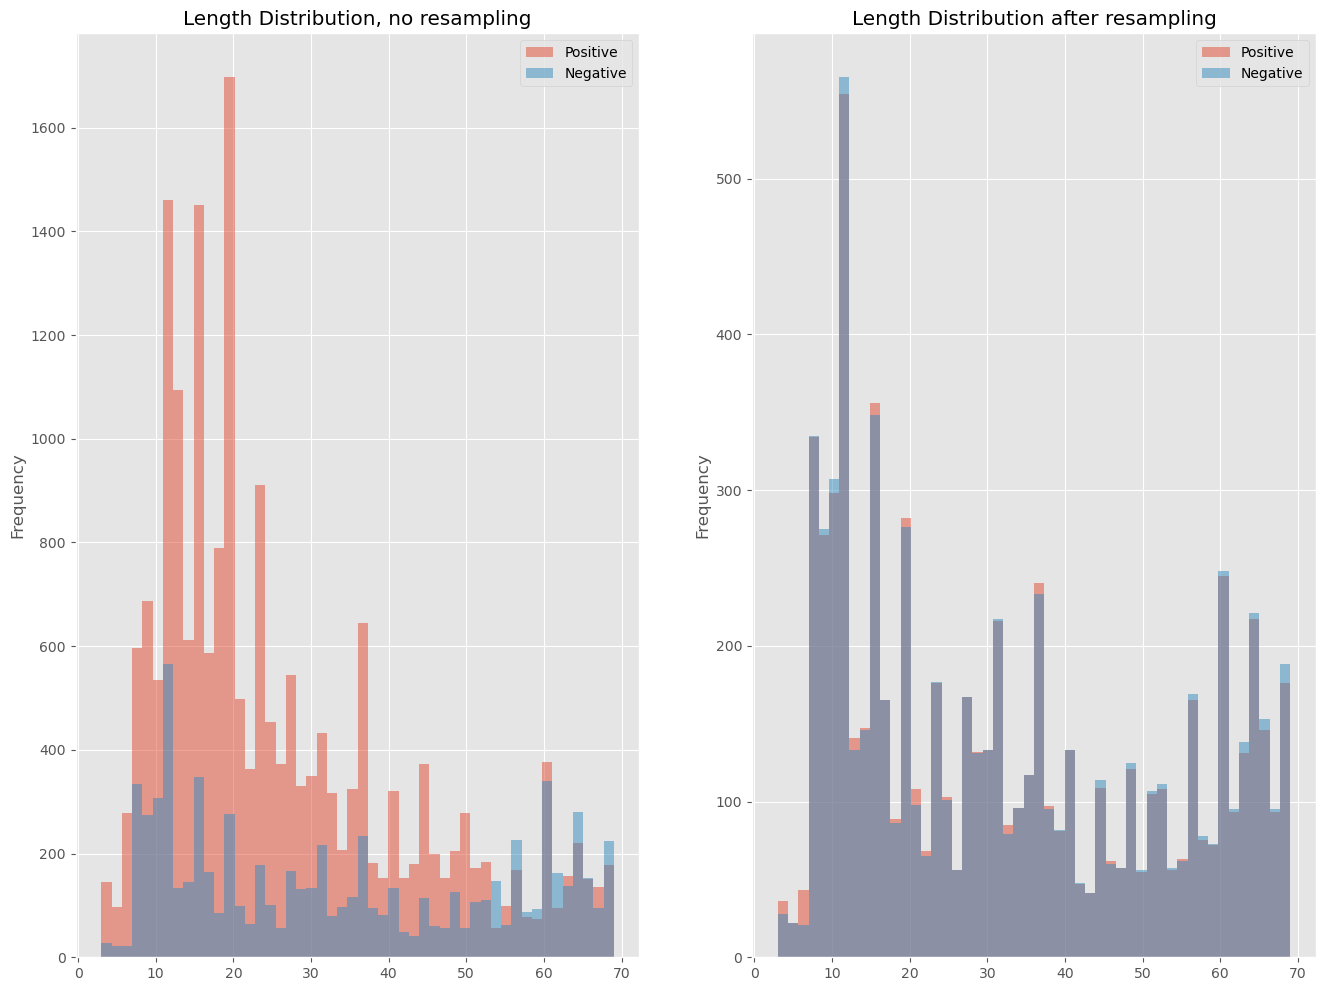

In [291]:
fig, ax = plt.subplots(1, 2)
pos.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Positive', legend=True, ax=ax[0])
neg.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Negative', legend=True, ax=ax[0])
ax[0].set_title('Length Distribution, no resampling')
df_p.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Positive', legend=True, ax=ax[1])
df_n.seq_len.plot(kind='hist', bins=50, density=False, alpha=0.5, label='Negative', legend=True, ax=ax[1])
ax[1].set_title('Length Distribution after resampling')

In [292]:
df_n.head(2)

,id,name,AB,description,OX,dataset,seq,seq_len
CA18_CONBE,A0A068B6Q6,CA18_CONBE,0,Conotoxin Bt1.8 (Fragment),Conus betulinus OX=89764,uniprot_swissprot.fasta,PDGRNAAAKAFDLITPTVRKGCCSNPACILNNPNQCG,37
PIOS1_HUMAN,A0A0B4J2F0,PIOS1_HUMAN,0,Protein PIGBOS1,Homo sapiens OX=9606 GN=PIGBOS1,uniprot_swissprot.fasta,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,54


In [293]:
df_p.head(2)

,id,name,AB,description,OX,dataset,seq,seq_len
342,ADAM_2177,InverPep_ADAM_2177,1,None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,32
2066,DBAASP13663,"HistoneH2A(1-21),Fi-Histin",1,None,alien,InverPep.fasta,SRSSRAGLQFPVGRIHRLLRK,21


In [294]:
print('dfp, dfn', df_p.shape, df_n.shape)
df = df_p.append(df_n, ignore_index=True)
print('df shape: ', df.shape)
df.head(2)

dfp, dfn (6983, 8) (6983, 8)
df shape:  (13966, 8)


/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_6403/4075074843.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_p.append(df_n, ignore_index=True)


,id,name,AB,description,OX,dataset,seq,seq_len
0,ADAM_2177,InverPep_ADAM_2177,1,None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,32
1,DBAASP13663,"HistoneH2A(1-21),Fi-Histin",1,None,alien,InverPep.fasta,SRSSRAGLQFPVGRIHRLLRK,21


In [295]:
ofile = 'new_data_pos_neg'
destin = ofile.split('.csv')[0]+'.csv'
df.to_csv(destin, index = False, encoding='utf-8')
print('saved pd datafrae as csv to:', destin)

saved pd datafrae as csv to: new_data_pos_neg.csv
